# Fashion MNIST Image Classification
## ST1504 Deep Learning CA1 Part A

##### Name: Haja Amir Rahman
##### Class: DAAA/FT/2B/06
##### Admin Number: P2100803

## References:
- [ResNet50](https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691)
- [Flipping & cropping images](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right)

<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The Fashion MNIST Dataset is a dataset of Zalando's images, with 60000 examples for training and 10000 examples for testing. Each example is a 28x28 greyscale image, with 10 associated labels.

* Import all modules
* Load dataset
* Rescale test and train images

In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

import keras
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import pandas as pd
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras import layers
from tensorflow.keras import Sequential

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 
'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1, shuffle=False)
x_test = x_test/255
x_val = x_val/255
x_train = x_train/255

In [5]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(54000, 28, 28) (54000,)
(6000, 28, 28) (6000,)
(10000, 28, 28) (10000,)


* 54000 images of 28 pixels by 28 pixels for training and 54000 labels to pair with the images

* 6000 images of 28 x 28 for validation and 6000 labels

* 10000 images of 28 pixels by 28 pixels for testing and 10000 labels to pair with the images

- 28x28 image loaded

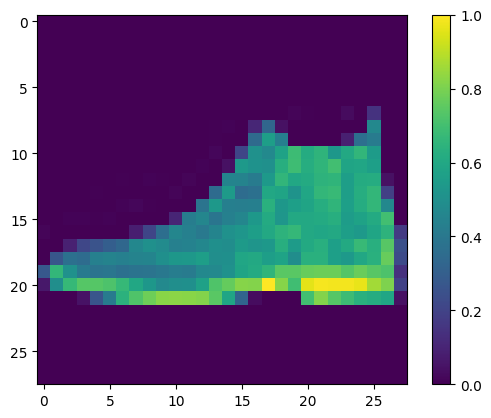

In [6]:
plt.figure()
plt.imshow(x_test[0])
plt.colorbar()
plt.grid(False)
plt.show()

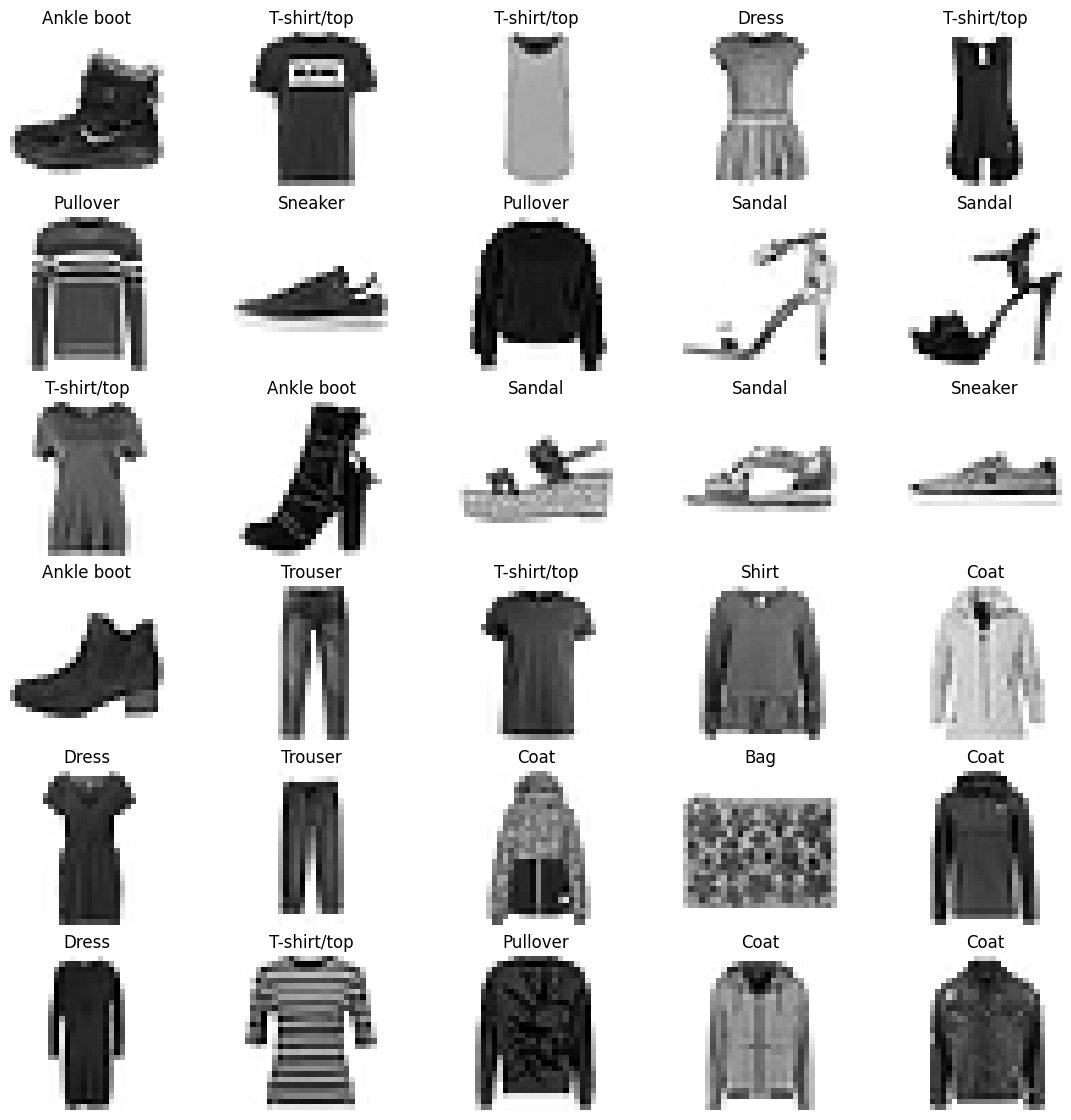

In [7]:
import matplotlib.pyplot as plt

NUM_ROW = 6               # CHANGE THIS
NUM_COL = 5               # CHANGE THIS
WIDTH = 14                # CHANGE THIS
HEIGHT = 14               # CHANGE THIS

fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=(WIDTH, HEIGHT))
row_i = 0
col_i = 0

for i in range(30):        # CHANGE THIS

    img = x_train[i]
    label = y_train[i]
    
    ax[row_i, col_i].imshow(img, cmap=plt.cm.binary)
    ax[row_i, col_i].set_title(f"{class_names[label]}")
    ax[row_i, col_i].axis("off")

    col_i += 1
    if col_i > NUM_COL-1:
        row_i += 1
        col_i = 0
        
plt.show()

<h2>Objectives/Tasks</h2>

* Be able to accurately identify the test images fed to the model
* Get highest possible accuracy and loss (>95% accuracy)
* Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

* Defined function to execute flipping and tilting on training images

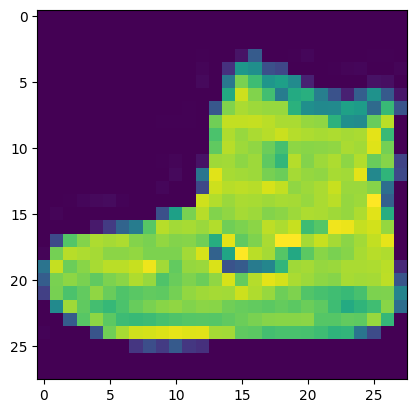

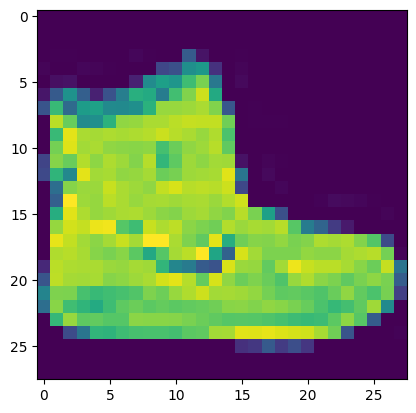

In [8]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(tf.image.flip_left_right(x_train[0].reshape((*x_train[0].shape,1))))
plt.show()

(54000, 28, 28)


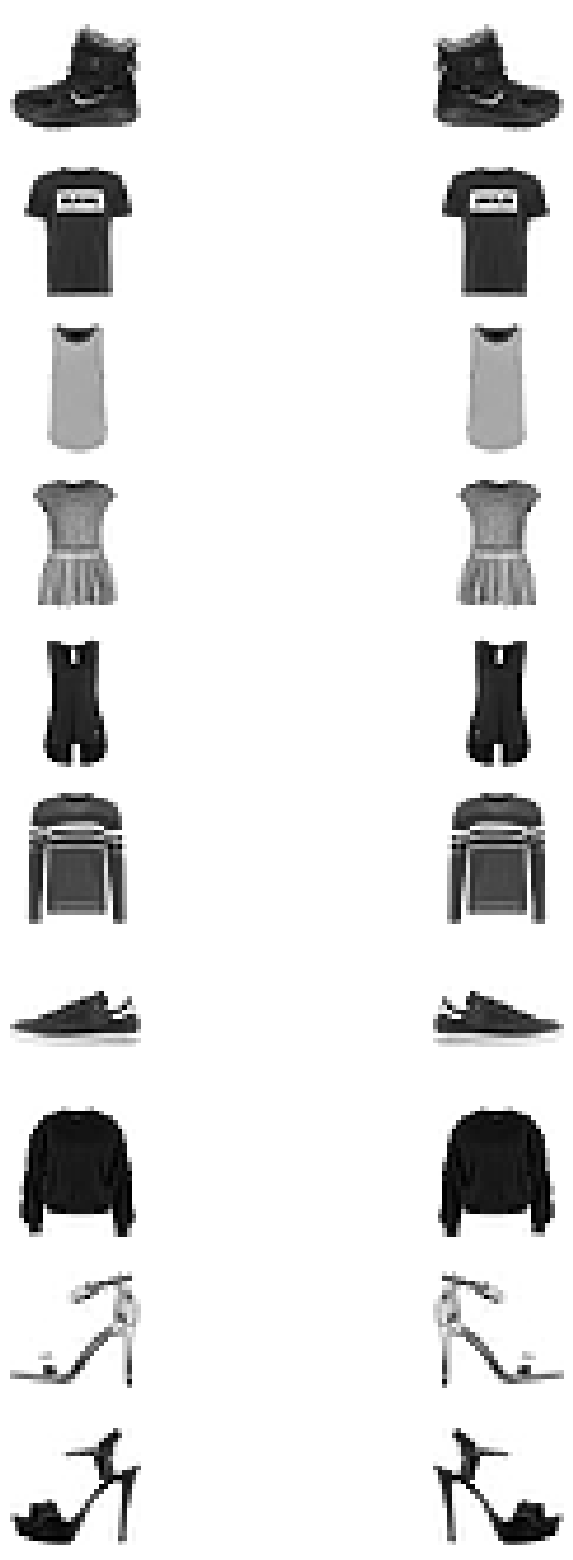

In [9]:
def flipall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.flip_left_right(images).numpy()
    images = images.reshape(images.shape[:3])

    return images
    
x_train_flipped = flipall(x_train)
print(x_train_flipped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_flipped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()
    

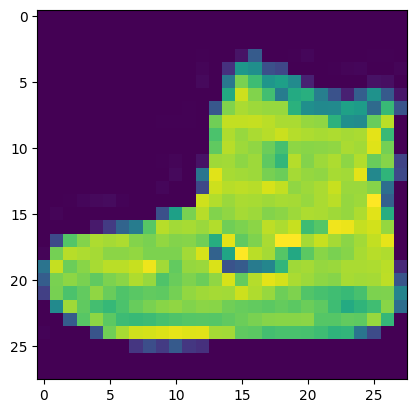

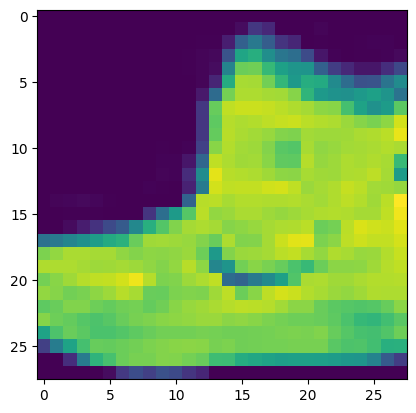



(54000, 28, 28)


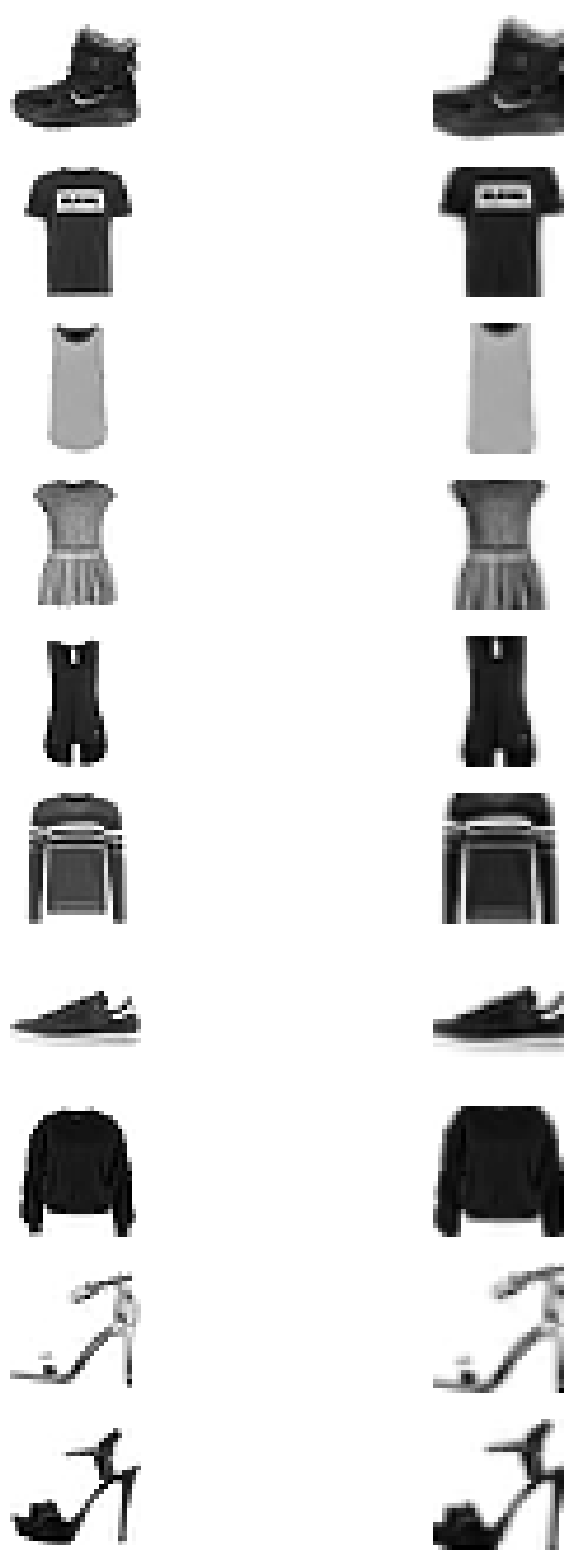

In [10]:
def cropall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.central_crop(images, 0.8)
    images = tf.image.resize(images, (28,28))
    images = images.numpy().reshape(images.shape[:3])

    return images

cropped_test = cropall(x_train[0])
plt.imshow(x_train[0])
plt.show()
plt.imshow(cropped_test)
plt.show()

print("\n"+"="*50+"\n")
    
x_train_cropped = cropall(x_train)
print(x_train_cropped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_cropped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()

# Simple Baseline Model

In [11]:
model = Sequential([
    layers.Conv2D(64, (4,4), activation="relu", input_shape=(28, 28, 1)),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(128, activation="relu"),
    layers.Dense(10)
])

#copy pasted from documentation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

baseline_history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
baseline_history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 64)        1088      
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 128)               5120128   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,122,506
Trainable params: 5,122,506
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1688/1688 [==============================] - 18s 8ms/step - loss: 0.3846 - accuracy: 0.8631 - val_loss: 0.3155 - val_accuracy: 0.8827
Epoch 2/5
1688/1688 [========

In [12]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3107 - accuracy: 0.9063


[0.3107306659221649, 0.9063000082969666]

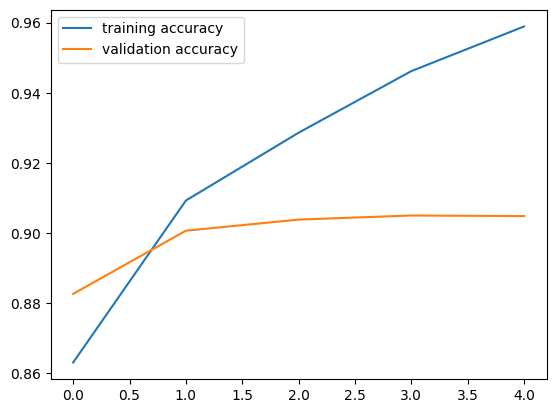

In [13]:
plt.plot(baseline_history.history['accuracy'], label='training accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='validation accuracy')
plt.legend()

plt.show()

#### baseline model containing simple Conv2D layer gets testing accuracy of 90%

<h3><b>3. Modelling & Evaluation</h3></b>

<h3>Metrics Used</h3>

* Top 1 accuracy
* Top 3 accuracy
* Loss

# Resnet50

In [14]:
# ATTENTION. train using school lab computer with GPU

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def res_identity(x, filters): 
    #renet block where dimension doesnot change.
    #The skip connection is just simple identity conncection
    #we will have 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def res_conv(x, s, filters):
    '''
    here the input size changes''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def resnet50():
    input_im = Input(shape=(28,28,1)) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(10, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

resnet50_model = resnet50()
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [15]:
import scipy
train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
batch_size=64

train_lab_categorical = tf.keras.utils.to_categorical(
    y_train, num_classes=10, dtype='uint8')

train_set_conv = train_DataGen.flow(x_train.reshape((*x_train.shape,1)), train_lab_categorical, batch_size=batch_size)

resnet_history = resnet50_model.fit(train_set_conv, epochs=100)

Epoch 1/100
844/844 [==============================] - 84s 87ms/step - loss: 12.8978 - acc: 0.6687
Epoch 2/100
844/844 [==============================] - 74s 87ms/step - loss: 5.8621 - acc: 0.7238
Epoch 3/100
844/844 [==============================] - 75s 89ms/step - loss: 3.6361 - acc: 0.7454
Epoch 4/100
844/844 [==============================] - 74s 88ms/step - loss: 2.6332 - acc: 0.7494
Epoch 5/100
844/844 [==============================] - 75s 88ms/step - loss: 2.5162 - acc: 0.7522
Epoch 6/100
844/844 [==============================] - 74s 88ms/step - loss: 2.1705 - acc: 0.7420
Epoch 7/100
844/844 [==============================] - 74s 88ms/step - loss: 2.0399 - acc: 0.7355
Epoch 8/100
844/844 [==============================] - 75s 89ms/step - loss: 2.0562 - acc: 0.7556
Epoch 9/100
844/844 [==============================] - 74s 87ms/step - loss: 2.0175 - acc: 0.7237
Epoch 10/100
844/844 [==============================] - 72s 85ms/step - loss: 1.3847 - acc: 0.7600
Epoch 11/100
844/8

<h3><b>4. Model Improvement</h3></b>

In [16]:
x_train_augmented = list(x_train) + list(x_train_flipped) + list(x_train_cropped)
x_train_augmented = np.array(x_train_augmented)

y_train_augmented = np.array(list(y_train) * 3)

x_train_augmented.shape, y_train_augmented.shape

((162000, 28, 28), (162000,))

In [17]:
baseline_augmented_model = Sequential([
    layers.Conv2D(64, (4,4), activation="relu", input_shape=(28, 28, 1)),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(128, activation="relu"),
    layers.Dense(10)
])

#copy pasted from documentation
baseline_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(baseline_augmented_model.summary())

baseline_augmented_history = baseline_augmented_model.fit(x_train_augmented, y_train_augmented, epochs=5, validation_data=(x_val, y_val))
baseline_augmented_history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 25, 25, 64)        1088      
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               5120128   
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,122,506
Trainable params: 5,122,506
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 31s 6ms/step - loss: 0.3626 - accuracy: 0.8677 - val_loss: 0.2985 - val_accuracy: 0.8882
Epoch 2/5
5063/5063 [======

In [18]:
baseline_augmented_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3869 - accuracy: 0.9104


[0.38691049814224243, 0.9103999733924866]

In [21]:
# baseline_augmented_model.save_weights("baseline_augmented_model.h5")

In [20]:
# resnet 50 but augmented data

resnet50_augmented_model = resnet50()
resnet50_augmented_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

train_augmented_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
batch_size=64

train_labels_augmented_categorical = tf.keras.utils.to_categorical(
    y_train_augmented, num_classes=10, dtype='uint8')

train_augmented_set_conv = train_augmented_DataGen.flow(x_train_augmented.reshape((*x_train_augmented.shape,1)), train_labels_augmented_categorical, batch_size=batch_size)

resnet_history = resnet50_model.fit(train_augmented_set_conv, epochs=100)

Epoch 1/100
2532/2532 [==============================] - 191s 75ms/step - loss: 0.4499 - acc: 0.8587
Epoch 2/100
2532/2532 [==============================] - 192s 76ms/step - loss: 0.4468 - acc: 0.8603
Epoch 3/100
2532/2532 [==============================] - 197s 78ms/step - loss: 0.4451 - acc: 0.8612
Epoch 4/100
2532/2532 [==============================] - 227s 90ms/step - loss: 0.4423 - acc: 0.8612
Epoch 5/100
2532/2532 [==============================] - 218s 86ms/step - loss: 0.4400 - acc: 0.8628
Epoch 6/100
2266/2532 [=========================>....] - ETA: 22s - loss: 0.4414 - acc: 0.8618

KeyboardInterrupt: 